# Text Generation using LSTM and GRU

This project focuses on building a character-level text generation model using Shakespeare's works. We implemented and compared GRU and LSTM-based RNNs using PyTorch, performed hyperparameter tuning, and deployed a web app using Streamlit.

##  Team Members & Contributions

| Name           | Role                                               |
|----------------|----------------------------------------------------|
| Ganesh Poudel  | Data cleaning,exploration & preprocessing          |
|Ranjan Khatiwada| Model development (GRU, LSTM)                      |
|Jyoti P. Uprety | Hyperparameter tuning & evaluation                 |
|Bibek Ghimirea  | Streamlit app development & cloud deployment       |

In [1]:
import os
import re
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split   
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
from itertools import product


In [2]:
# Environment Info & GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" PyTorch version:", torch.__version__)
print(" Using device:", device)

 PyTorch version: 2.6.0+cu126
 Using device: cuda


In [3]:
# Data Cleaning
with open('../data/shakespeare.txt', "r", encoding="utf-8") as f:
    text = f.read()
text = re.sub(r'[^\x00-\x7F]+', '', text)
text = re.sub(r'\s+', ' ', text)
print(f"Length of cleaned text: {len(text)}")

Length of cleaned text: 4941134


# Dataset Description
Name: Shakespeare Text Corpus

Source: TensorFlow Datasets – Shakespeare

Format: Plain text file (.txt)

Content: Collection of Shakespeare’s plays and sonnets, written in Early Modern English

# Key Statistics (After Cleaning)
Total characters: 4,941,134

Character set: Letters (a–z, A–Z), digits, punctuation, and whitespace

Language style: Rich in dialogues, archaic words (e.g., thou, thy, thee), stage directions

Structure: Continuous string without explicit labels (ideal for character-level language modeling)

#  Why this dataset?
Highly suitable for sequence modeling tasks such as:

-Text generation

-Next-character prediction

-Common benchmark for evaluating RNNs, especially GRU and LSTM-based models.

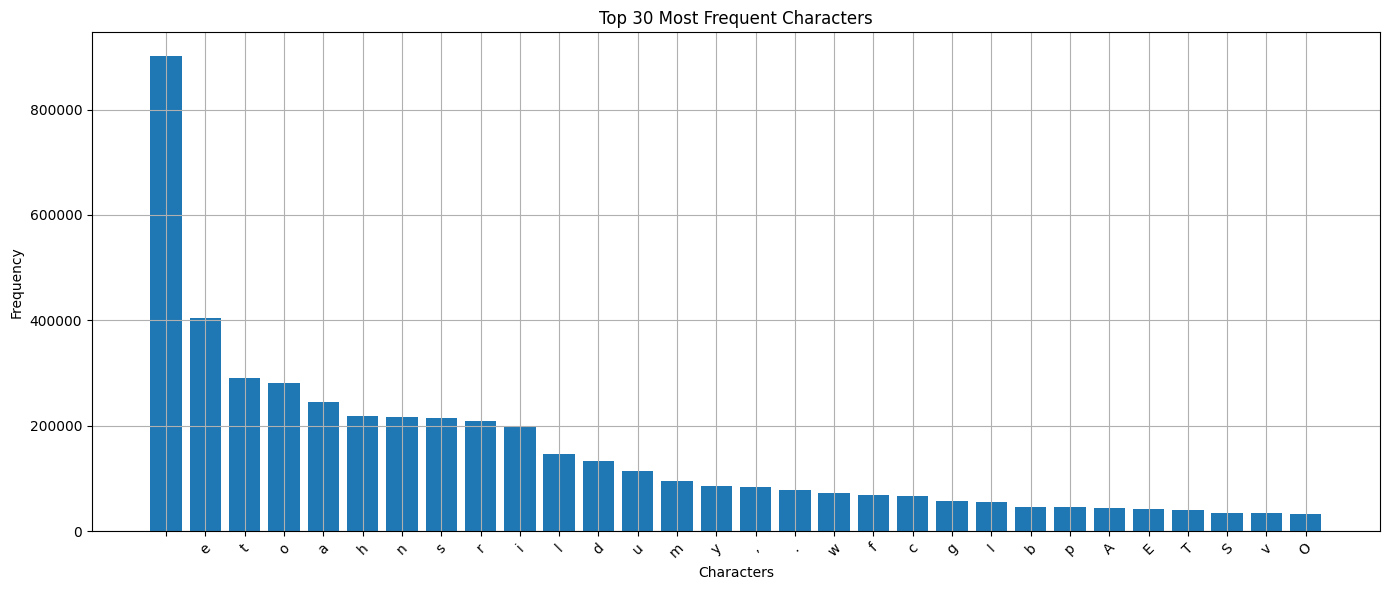

In [4]:

# Detailed Data Exploration
# Character frequency
char_counts = Counter(text)
chars, freqs = zip(*sorted(char_counts.items(), key=lambda x: -x[1]))
plt.figure(figsize=(14, 6))
plt.bar(chars[:30], freqs[:30])
plt.title("Top 30 Most Frequent Characters")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

This bar chart displays the 30 most frequent characters in the Shakespeare dataset. As expected in English texts:

The space character ' ' is the most frequent, appearing over 900,000 times.

Common vowels such as 'e', 't', 'o', and 'a' follow closely.

Frequently used consonants like 'n', 's', 'r', and 'h' are also prominent.

Punctuation marks like '.' and ',' appear due to sentence structures and dialogue formatting in plays.

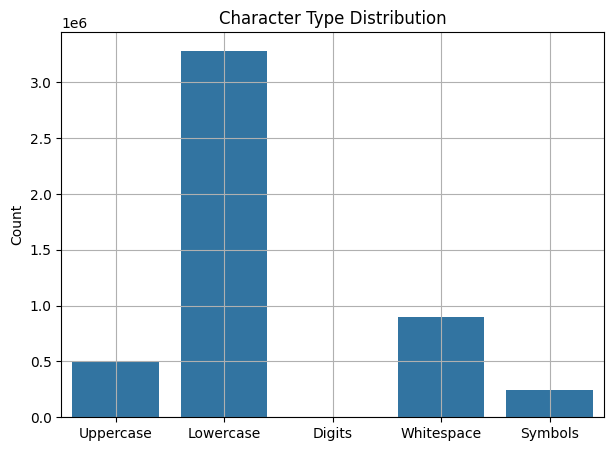

In [5]:
# Character type distribution
upper = sum(1 for c in text if c.isupper())
lower = sum(1 for c in text if c.islower())
digits = sum(1 for c in text if c.isdigit())
spaces = sum(1 for c in text if c.isspace())
symbols = len(text) - upper - lower - digits - spaces

char_type_labels = ['Uppercase', 'Lowercase', 'Digits', 'Whitespace', 'Symbols']
char_type_values = [upper, lower, digits, spaces, symbols]

plt.figure(figsize=(7, 5))
sns.barplot(x=char_type_labels, y=char_type_values)
plt.title("Character Type Distribution")
plt.ylabel("Count")
plt.grid(True)
plt.show()

This bar chart breaks down the dataset into different types of characters used in the Shakespeare text:

Lowercase letters dominate the corpus, with over 3 million occurrences, indicating the high volume of natural dialogue and narrative content.

Uppercase characters are significantly fewer, mostly representing names or scene headings.

Whitespace includes spaces and newline characters, used heavily for formatting and sentence separation.

Symbols (like punctuation marks) account for structural flow — e.g., , . : ; ? !.

Digits are almost negligible or absent, which is expected since Shakespearean works contain minimal numeric references.

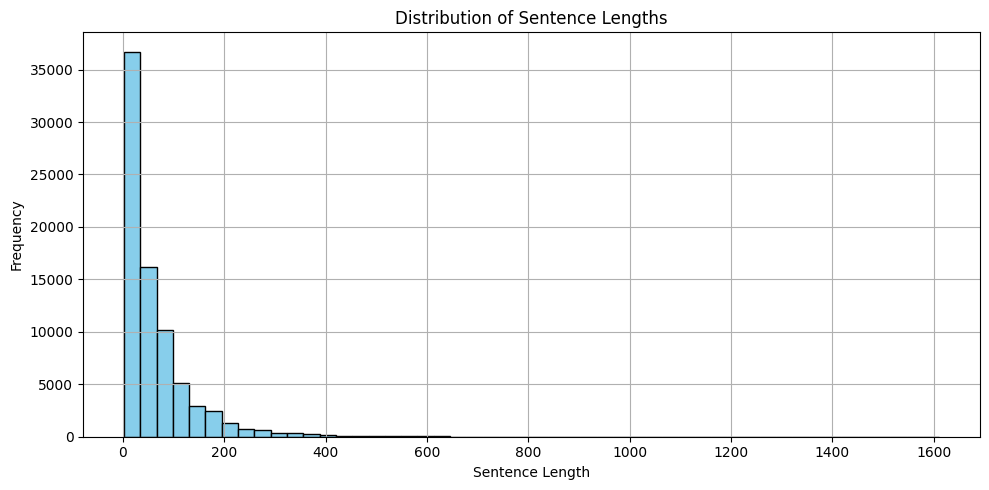

In [6]:
# Sentence length distribution
sentence_lengths = [len(s) for s in text.split('.') if len(s.strip()) > 1]
plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

This histogram shows the distribution of sentence lengths (in number of characters) within the Shakespeare dataset:

The majority of sentences are short, with lengths between 20–100 characters, peaking around 30–40 characters.

The distribution is right-skewed, meaning a few very long sentences stretch out the tail.

Extremely long sentences (500+ characters) are rare but exist due to Shakespeare’s complex literary style.

This insight helps guide sequence length (seq_len) decisions in the model. A typical sequence length of 100–200 is ideal to balance training efficiency with information retention.

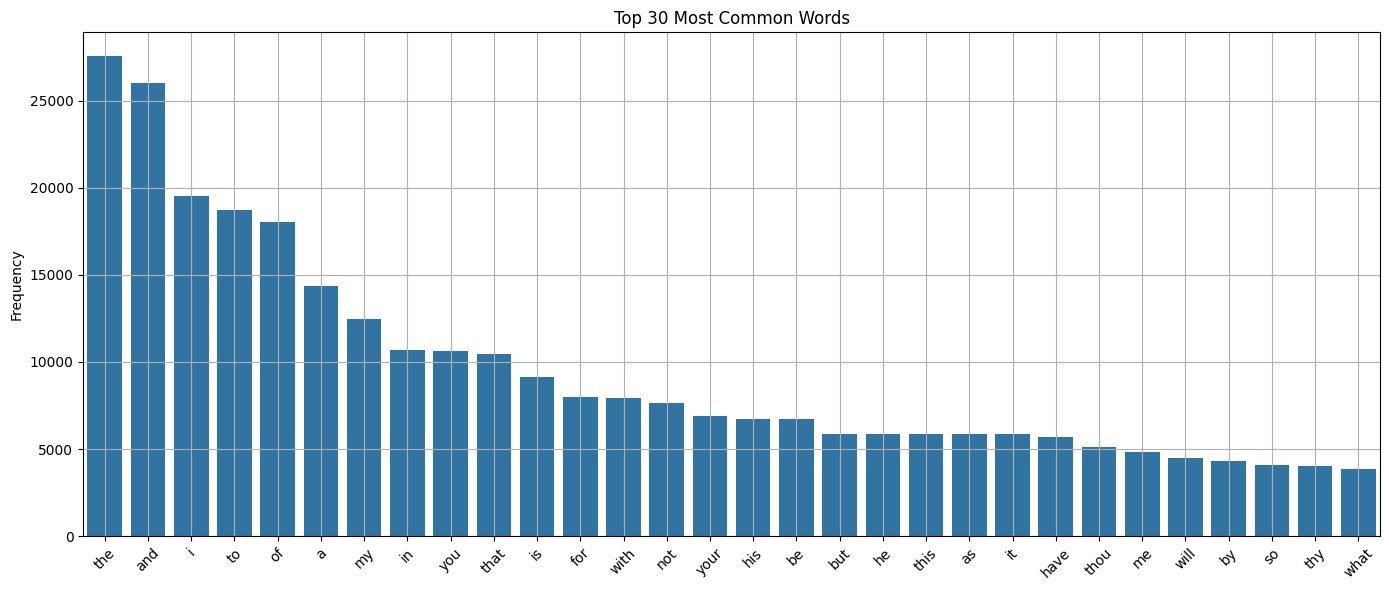

In [7]:
# Word frequency distribution
words = text.lower().split()
word_counts = Counter(words)
common_words, word_freqs = zip(*word_counts.most_common(30))
plt.figure(figsize=(14, 6))
sns.barplot(x=list(common_words), y=list(word_freqs))
plt.title("Top 30 Most Common Words")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

This bar chart displays the 30 most frequently used words in the Shakespeare corpus:

Common English stop words such as “the,” “and,” “i,” “to,” “of,” dominate the list, reflecting natural language structure.

Pronouns like “you,” “my,” “your,” “his,” “me,” and verbs like “is,” “have,” “will” appear frequently, aligning with Shakespeare’s dialogue-heavy writing style.

Archaic words like “thou” and “thy” highlight the historical nature of the text.

This distribution reflects both syntactic function (articles, prepositions) and semantic relevance (characters addressing one another), and supports the richness of language modeling.

In [8]:
# Step 4: Feature Engineering
vocab = sorted(set(text))
char2idx = {ch: idx for idx, ch in enumerate(vocab)}
idx2char = {idx: ch for idx, ch in enumerate(vocab)}
encoded_text = np.array([char2idx[c] for c in text])

with open("../data/char2idx.pkl", "wb") as f:
    pickle.dump(char2idx, f)
with open("../data/idx2char.pkl", "wb") as f:
    pickle.dump(idx2char, f)

In [9]:
#Model Definitions
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden


class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

In [ ]:
def train_model(model_class, name, vocab_size, data, embedding_dim, hidden_dim,
                num_layers, dropout, lr, batch_size, seq_length, epochs=20, patience=5, max_samples=None):

    model = model_class(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()


    # Dataset Preparation with optional sample limit
    class TextDataset(torch.utils.data.Dataset):
        def __init__(self, data, seq_len, max_samples=None):
            self.data = data
            self.seq_len = seq_len
            self.total_len = len(data) - seq_len
            if max_samples:
                self.total_len = min(self.total_len, max_samples)

        def __len__(self):
            return self.total_len

        def __getitem__(self, idx):
            return (
                torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long),
                torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long),
            )

    dataset = TextDataset(data, seq_length, max_samples=max_samples)
    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    best_val_loss = float('inf')
    best_val_acc = 0.0
    early_stop_counter = 0
    val_losses, val_accuracies, perplexities = [], [], []
    train_losses, train_accuracies = [], []


    os.makedirs("../data/model", exist_ok=True)
    os.makedirs("../evaluation", exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        all_preds, all_labels = [], []

        print(f"\nEpoch {epoch+1}/{epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for x_batch, y_batch in train_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output, _ = model(x_batch)
            loss = loss_fn(output.view(-1, vocab_size), y_batch.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            train_loss += loss.item()

            all_preds.extend(output.argmax(-1).detach().cpu().numpy().flatten())
            all_labels.extend(y_batch.detach().cpu().numpy().flatten())

        train_acc = accuracy_score(all_labels, all_preds)
        

        # Validation
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for x_batch, y_batch in val_bar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output, _ = model(x_batch)
                loss = loss_fn(output.view(-1, vocab_size), y_batch.view(-1))
                val_loss += loss.item()
                val_preds.extend(output.argmax(-1).detach().cpu().numpy().flatten())
                val_labels.extend(y_batch.detach().cpu().numpy().flatten())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        perplexity = np.exp(val_loss)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        perplexities.append(perplexity)
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        print(f"-- Epoch {epoch+1}: TrainAcc={train_acc:.4f} | ValLoss={val_loss:.4f} | ValAcc={val_acc:.4f} | PPL={perplexity:.2f}")

        # Save best models
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"../data/model/{name}_best_loss.pth")
            early_stop_counter = 0  # Reset counter on improvement
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(" Early stopping triggered.")
                break
    return {
                "Model": name,
                "Embedding Dim": embedding_dim,
                "Hidden Dim": hidden_dim,
                "Num Layers": num_layers,
                "Dropout": dropout,
                "LR": lr,
                "Batch Size": batch_size,
                "Best Val Loss": min(val_losses),
                "Best Val Accuracy": max(val_accuracies),
                "Best Perplexity": min(perplexities),
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies,
                "perplexities": perplexities
            }

In [11]:
# Set device again for safety
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use actual encoded text and vocab from earlier preprocessing
vocab_size = len(vocab)

# Grid Setup for hyperparameter tuning
embedding_dims = [128, 256]
hidden_dims = [256, 512]
num_layers_list = [2]
dropouts = [0.0, 0.3]
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]
seq_length = 100



model_classes = {"GRU": GRU, "LSTM": LSTM}

grid = list(product(model_classes.keys(), embedding_dims, hidden_dims, num_layers_list, dropouts, learning_rates, batch_sizes))


# Run Grid Search
results = []
for model_name, emb, hid, layers, drop, lr, batch in grid:
    model_class = model_classes[model_name]
    model_id = f"{model_name}_emb{emb}_hid{hid}_layers{layers}_drop{drop}_lr{lr}_batch{batch}"
    result = train_model(model_class, model_id, vocab_size, encoded_text,
                         embedding_dim=emb, hidden_dim=hid,
                         num_layers=layers, dropout=drop,
                         lr=lr, batch_size=batch, seq_length=seq_length, max_samples=10000)
    results.append(result)


Epoch 1/20


-- Epoch 1: TrainAcc=0.6359 | ValLoss=0.2045 | ValAcc=0.9560 | PPL=1.23

Epoch 2/20


-- Epoch 2: TrainAcc=0.9669 | ValLoss=0.1226 | ValAcc=0.9688 | PPL=1.13

Epoch 3/20


KeyboardInterrupt: 

In [12]:
# Save and show results
df_results = pd.DataFrame(results)
df_results.to_csv("../evaluation/final_hyperparameter_results.csv", index=False)

In [13]:
df_results

""


In [14]:
# Create combined score
df_results['Combined Score'] = df_results['Best Val Accuracy'] / df_results['Best Perplexity']

# Step 2: Filter for GRU and LSTM
gru_results = df_results[df_results['Model'].str.startswith('GRU')]
lstm_results = df_results[df_results['Model'].str.startswith('LSTM')]

# Step 3: Find best for each
best_gru = gru_results.loc[gru_results['Combined Score'].idxmax()]
best_lstm = lstm_results.loc[lstm_results['Combined Score'].idxmax()]

# Step 4: Print results
print(" Best GRU Model:\n", best_gru)
print("\n Best LSTM Model:\n", best_lstm)


KeyError: 'Best Val Accuracy'

In [11]:
# ==== Hyperparameters from best models ====
embedding_dim = 256
hidden_dim = 512
num_layers = 2
dropout = 0.3
lr = 0.001
batch_size = 128
seq_length = 100
epochs = 30
patience = 5

In [12]:
#Train GRU
gru_result = train_model(
    model_class=GRU,
    name="GRU_FINAL_FULL",
    vocab_size=len(vocab),
    data=encoded_text,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    seq_length=seq_length,
    epochs=epochs,
    patience=patience,
    max_samples=200000
)

# Save best GRU model with clear name
gru_model = GRU(len(vocab), embedding_dim, hidden_dim, num_layers, dropout).to(device)
gru_model.load_state_dict(torch.load("../data/model/GRU_FINAL_FULL_best_loss.pth"))
torch.save(gru_model.state_dict(), "../data/model/best_model_gru.pth")
print(" GRU saved as best_model_gru.pth")


Epoch 1/30


-- Epoch 1: TrainAcc=0.6420 | ValLoss=0.4642 | ValAcc=0.8690 | PPL=1.59

Epoch 2/30


-- Epoch 2: TrainAcc=0.8659 | ValLoss=0.2163 | ValAcc=0.9436 | PPL=1.24

Epoch 3/30


-- Epoch 3: TrainAcc=0.9068 | ValLoss=0.1825 | ValAcc=0.9508 | PPL=1.20

Epoch 4/30


-- Epoch 4: TrainAcc=0.9179 | ValLoss=0.1732 | ValAcc=0.9523 | PPL=1.19

Epoch 5/30


-- Epoch 5: TrainAcc=0.9231 | ValLoss=0.1686 | ValAcc=0.9530 | PPL=1.18

Epoch 6/30


-- Epoch 6: TrainAcc=0.9259 | ValLoss=0.1646 | ValAcc=0.9538 | PPL=1.18

Epoch 7/30


-- Epoch 7: TrainAcc=0.9280 | ValLoss=0.1620 | ValAcc=0.9540 | PPL=1.18

Epoch 8/30


-- Epoch 8: TrainAcc=0.9297 | ValLoss=0.1612 | ValAcc=0.9540 | PPL=1.17

Epoch 9/30


-- Epoch 9: TrainAcc=0.9309 | ValLoss=0.1589 | ValAcc=0.9545 | PPL=1.17

Epoch 10/30


-- Epoch 10: TrainAcc=0.9319 | ValLoss=0.1588 | ValAcc=0.9546 | PPL=1.17

Epoch 11/30


-- Epoch 11: TrainAcc=0.9329 | ValLoss=0.1570 | ValAcc=0.9550 | PPL=1.17

Epoch 12/30


-- Epoch 12: TrainAcc=0.9336 | ValLoss=0.1561 | ValAcc=0.9551 | PPL=1.17

Epoch 13/30


-- Epoch 13: TrainAcc=0.9343 | ValLoss=0.1550 | ValAcc=0.9554 | PPL=1.17

Epoch 14/30


-- Epoch 14: TrainAcc=0.9348 | ValLoss=0.1550 | ValAcc=0.9553 | PPL=1.17

Epoch 15/30


-- Epoch 15: TrainAcc=0.9353 | ValLoss=0.1544 | ValAcc=0.9551 | PPL=1.17

Epoch 16/30


-- Epoch 16: TrainAcc=0.9359 | ValLoss=0.1537 | ValAcc=0.9554 | PPL=1.17

Epoch 17/30


-- Epoch 17: TrainAcc=0.9361 | ValLoss=0.1528 | ValAcc=0.9557 | PPL=1.17

Epoch 18/30


-- Epoch 18: TrainAcc=0.9367 | ValLoss=0.1525 | ValAcc=0.9558 | PPL=1.16

Epoch 19/30


-- Epoch 19: TrainAcc=0.9370 | ValLoss=0.1523 | ValAcc=0.9557 | PPL=1.16

Epoch 20/30


-- Epoch 20: TrainAcc=0.9372 | ValLoss=0.1520 | ValAcc=0.9558 | PPL=1.16

Epoch 21/30


-- Epoch 21: TrainAcc=0.9373 | ValLoss=0.1522 | ValAcc=0.9560 | PPL=1.16

Epoch 22/30


-- Epoch 22: TrainAcc=0.9377 | ValLoss=0.1511 | ValAcc=0.9560 | PPL=1.16

Epoch 23/30


-- Epoch 23: TrainAcc=0.9379 | ValLoss=0.1510 | ValAcc=0.9559 | PPL=1.16

Epoch 24/30


-- Epoch 24: TrainAcc=0.9382 | ValLoss=0.1508 | ValAcc=0.9558 | PPL=1.16

Epoch 25/30


-- Epoch 25: TrainAcc=0.9383 | ValLoss=0.1502 | ValAcc=0.9562 | PPL=1.16

Epoch 26/30


-- Epoch 26: TrainAcc=0.9385 | ValLoss=0.1502 | ValAcc=0.9562 | PPL=1.16

Epoch 27/30


-- Epoch 27: TrainAcc=0.9386 | ValLoss=0.1492 | ValAcc=0.9562 | PPL=1.16

Epoch 28/30


-- Epoch 28: TrainAcc=0.9387 | ValLoss=0.1500 | ValAcc=0.9562 | PPL=1.16

Epoch 29/30


-- Epoch 29: TrainAcc=0.9390 | ValLoss=0.1494 | ValAcc=0.9561 | PPL=1.16

Epoch 30/30


-- Epoch 30: TrainAcc=0.9391 | ValLoss=0.1490 | ValAcc=0.9564 | PPL=1.16
 GRU saved as best_model_gru.pth


In [13]:
#Train LSTM
lstm_result = train_model(
    model_class=LSTM,
    name="LSTM_FINAL_FULL",
    vocab_size=len(vocab),
    data=encoded_text,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    seq_length=seq_length,
    epochs=epochs,
    patience=patience,
    max_samples= 200000
)

# Save best LSTM model with clear name
lstm_model = LSTM(len(vocab), embedding_dim, hidden_dim, num_layers, dropout).to(device)
lstm_model.load_state_dict(torch.load("../data/model/LSTM_FINAL_FULL_best_loss.pth"))
torch.save(lstm_model.state_dict(), "../data/model/best_model_lstm.pth")
print(" LSTM saved as best_model_lstm.pth")



Epoch 1/30


-- Epoch 1: TrainAcc=0.6136 | ValLoss=0.5539 | ValAcc=0.8432 | PPL=1.74

Epoch 2/30


-- Epoch 2: TrainAcc=0.8692 | ValLoss=0.1916 | ValAcc=0.9465 | PPL=1.21

Epoch 3/30


-- Epoch 3: TrainAcc=0.9229 | ValLoss=0.1625 | ValAcc=0.9513 | PPL=1.18

Epoch 4/30


-- Epoch 4: TrainAcc=0.9332 | ValLoss=0.1533 | ValAcc=0.9532 | PPL=1.17

Epoch 5/30


-- Epoch 5: TrainAcc=0.9376 | ValLoss=0.1483 | ValAcc=0.9543 | PPL=1.16

Epoch 6/30


-- Epoch 6: TrainAcc=0.9405 | ValLoss=0.1450 | ValAcc=0.9551 | PPL=1.16

Epoch 7/30


-- Epoch 7: TrainAcc=0.9423 | ValLoss=0.1418 | ValAcc=0.9560 | PPL=1.15

Epoch 8/30


-- Epoch 8: TrainAcc=0.9439 | ValLoss=0.1398 | ValAcc=0.9564 | PPL=1.15

Epoch 9/30


-- Epoch 9: TrainAcc=0.9452 | ValLoss=0.1388 | ValAcc=0.9569 | PPL=1.15

Epoch 10/30


-- Epoch 10: TrainAcc=0.9462 | ValLoss=0.1370 | ValAcc=0.9571 | PPL=1.15

Epoch 11/30


-- Epoch 11: TrainAcc=0.9471 | ValLoss=0.1361 | ValAcc=0.9575 | PPL=1.15

Epoch 12/30


-- Epoch 12: TrainAcc=0.9479 | ValLoss=0.1352 | ValAcc=0.9578 | PPL=1.14

Epoch 13/30


-- Epoch 13: TrainAcc=0.9485 | ValLoss=0.1338 | ValAcc=0.9581 | PPL=1.14

Epoch 14/30


-- Epoch 14: TrainAcc=0.9491 | ValLoss=0.1334 | ValAcc=0.9582 | PPL=1.14

Epoch 15/30


-- Epoch 15: TrainAcc=0.9497 | ValLoss=0.1330 | ValAcc=0.9583 | PPL=1.14

Epoch 16/30


-- Epoch 16: TrainAcc=0.9501 | ValLoss=0.1325 | ValAcc=0.9585 | PPL=1.14

Epoch 17/30


-- Epoch 17: TrainAcc=0.9505 | ValLoss=0.1320 | ValAcc=0.9587 | PPL=1.14

Epoch 18/30


-- Epoch 18: TrainAcc=0.9510 | ValLoss=0.1314 | ValAcc=0.9588 | PPL=1.14

Epoch 19/30


-- Epoch 19: TrainAcc=0.9513 | ValLoss=0.1307 | ValAcc=0.9591 | PPL=1.14

Epoch 20/30


-- Epoch 20: TrainAcc=0.9516 | ValLoss=0.1303 | ValAcc=0.9591 | PPL=1.14

Epoch 21/30


-- Epoch 21: TrainAcc=0.9520 | ValLoss=0.1301 | ValAcc=0.9591 | PPL=1.14

Epoch 22/30


-- Epoch 22: TrainAcc=0.9522 | ValLoss=0.1297 | ValAcc=0.9594 | PPL=1.14

Epoch 23/30


-- Epoch 23: TrainAcc=0.9525 | ValLoss=0.1292 | ValAcc=0.9594 | PPL=1.14

Epoch 24/30


-- Epoch 24: TrainAcc=0.9528 | ValLoss=0.1290 | ValAcc=0.9595 | PPL=1.14

Epoch 25/30


-- Epoch 25: TrainAcc=0.9530 | ValLoss=0.1285 | ValAcc=0.9596 | PPL=1.14

Epoch 26/30


-- Epoch 26: TrainAcc=0.9532 | ValLoss=0.1282 | ValAcc=0.9598 | PPL=1.14

Epoch 27/30


-- Epoch 27: TrainAcc=0.9534 | ValLoss=0.1279 | ValAcc=0.9599 | PPL=1.14

Epoch 28/30


-- Epoch 28: TrainAcc=0.9536 | ValLoss=0.1280 | ValAcc=0.9597 | PPL=1.14

Epoch 29/30


-- Epoch 29: TrainAcc=0.9537 | ValLoss=0.1275 | ValAcc=0.9599 | PPL=1.14

Epoch 30/30


-- Epoch 30: TrainAcc=0.9540 | ValLoss=0.1272 | ValAcc=0.9600 | PPL=1.14
 LSTM saved as best_model_lstm.pth


In [14]:
def plot_full_training_curves(gru_result, lstm_result):
    epochs_range = range(1, len(gru_result['val_losses']) + 1)

    fig, axs = plt.subplots(3, 2, figsize=(20, 12))

    # Loss
    axs[0, 0].plot(epochs_range, gru_result['train_losses'], label='Train Loss')
    axs[0, 0].plot(epochs_range, gru_result['val_losses'], label='Val Loss')
    axs[0, 0].set_title("GRU - Loss")
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    axs[0, 1].plot(epochs_range, lstm_result['train_losses'], label='Train Loss')
    axs[0, 1].plot(epochs_range, lstm_result['val_losses'], label='Val Loss')
    axs[0, 1].set_title("LSTM - Loss")
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Accuracy
    axs[1, 0].plot(epochs_range, gru_result['train_accuracies'], label='Train Accuracy')
    axs[1, 0].plot(epochs_range, gru_result['val_accuracies'], label='Val Accuracy')
    axs[1, 0].set_title("GRU - Accuracy")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    axs[1, 1].plot(epochs_range, lstm_result['train_accuracies'], label='Train Accuracy')
    axs[1, 1].plot(epochs_range, lstm_result['val_accuracies'], label='Val Accuracy')
    axs[1, 1].set_title("LSTM - Accuracy")
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("Accuracy")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Perplexity
    axs[2, 0].plot(epochs_range, gru_result['perplexities'], label='Perplexity')
    axs[2, 0].set_title("GRU - Perplexity")
    axs[2, 0].set_xlabel("Epochs")
    axs[2, 0].set_ylabel("Perplexity")
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    axs[2, 1].plot(epochs_range, lstm_result['perplexities'], label='Perplexity')
    axs[2, 1].set_title("LSTM - Perplexity")
    axs[2, 1].set_xlabel("Epochs")
    axs[2, 1].set_ylabel("Perplexity")
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    plt.tight_layout()
    plt.show()

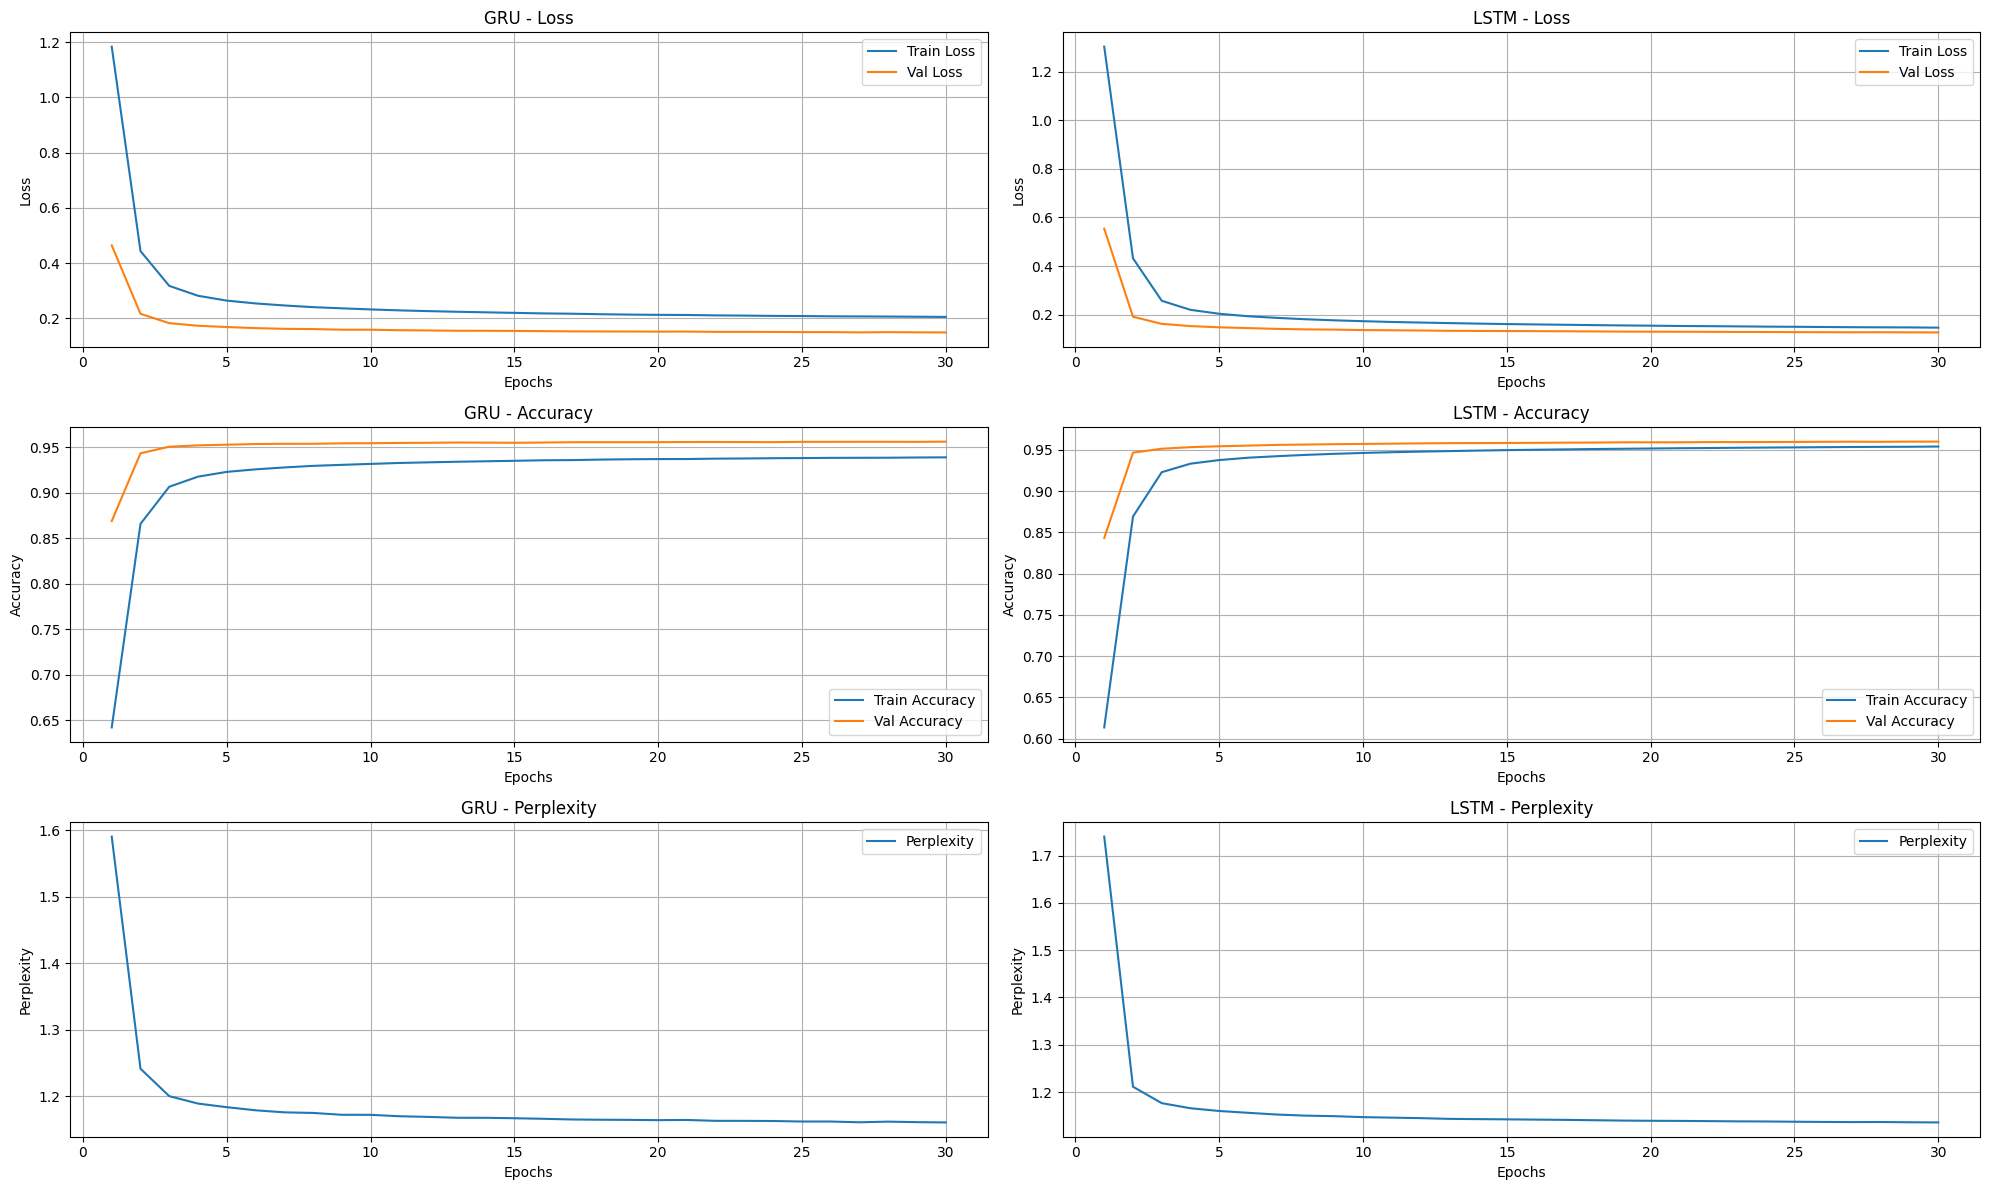

In [15]:
plot_full_training_curves(gru_result, lstm_result)

With the full dataset and extended training over 30 epochs, both GRU and LSTM models demonstrate strong and stable performance. Training and validation loss decrease rapidly in the initial epochs and plateau smoothly, indicating effective convergence without overfitting. Accuracy improves quickly, reaching around 95% for both models, with minimal gap between training and validation curves, reflecting good generalization. Perplexity, a measure of prediction confidence, also drops significantly and stabilizes just above 1.1 for both models. Overall, GRU converges slightly faster, but both models achieve nearly identical final performance in terms of accuracy and stability

In [16]:
def generate_text(model_class, checkpoint_path, seed_text, char2idx, idx2char, vocab_size,
                  embedding_dim, hidden_dim, num_layers=1, temperature=1.0, gen_length=300):
    
    # Prepare the model
    model = model_class(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    # Encode the seed text
    input_eval = torch.tensor([char2idx[c] for c in seed_text], dtype=torch.long).unsqueeze(0).to(device)
    generated = list(seed_text)

    hidden = None
    with torch.no_grad():
        for _ in range(gen_length):
            output, hidden = model(input_eval, hidden)
            predictions = output[:, -1, :] / temperature  # shape: (1, vocab_size)
            probs = torch.softmax(predictions, dim=-1).squeeze().cpu().numpy()
            next_char_idx = np.random.choice(len(probs), p=probs)
            next_char = idx2char[next_char_idx]
            generated.append(next_char)

            input_eval = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return ''.join(generated)


In [18]:
# Load mappings
with open("../data/char2idx.pkl", "rb") as f:
    char2idx = pickle.load(f)
with open("../data/idx2char.pkl", "rb") as f:
    idx2char = pickle.load(f)

# Common generation settings
seed_text = "But, soft! what light through yonder window breaks?"
vocab_size = len(char2idx)
embedding_dim = 256
hidden_dim = 512
num_layers = 2

# Generate from LSTM
lstm_path = "../data/model/best_model_lstm.pth"
lstm_output = generate_text(
    model_class=LSTM,
    checkpoint_path=lstm_path,
    seed_text=seed_text,
    char2idx=char2idx,
    idx2char=idx2char,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    temperature=1.0,
    gen_length=100
)

# Generate from GRU
gru_path = "../data/model/best_model_gru.pth"
gru_output = generate_text(
    model_class=GRU,
    checkpoint_path=gru_path,
    seed_text=seed_text,
    char2idx=char2idx,
    idx2char=idx2char,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    temperature=1.0,
    gen_length=100
)

# Print Results
print(" LSTM Output:")
print(lstm_output)

print("\n GRU Output:")
print(gru_output)


 LSTM Output:
But, soft! what light through yonder window breaks? O thou mine, I thine, Even as when first I hallowed thy fair name. So that eternal love in me, To e

 GRU Output:
But, soft! what light through yonder window breaks? Before I live, Intonboth, thy inward love of heart. 27 Being your vassal bound to stay your leisure
